# GRAPH and DEEP WALK

reference paper : https://arxiv.org/abs/1403.6652?ref=graphusergroup.com


In [3]:
# 필요한 모든 라이브러리 임포트
import numpy as np
import pandas as pd
import random
import networkx as nx
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

# CORA 데이터셋 로드
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]

# torch_geometric의 데이터를 NetworkX 그래프로 변환
edge_index = data.edge_index
edges = edge_index.t().numpy()
G = nx.from_edgelist(edges, create_using=nx.Graph())

Processing...
Done!


## Walk with Adjacency Matrix

- random walk 알고리즘을 통해 adjacency matrix를 활용할 수 있다.

### Random Walk

- 특정 node에서 시작해서 특정 방향으로 나아가는 과정을 말한다. 
- GNN에서 많이 활용한다. node representation을 학습할 때
- 무작위로 방문한 노드들 중에 빈번하게 방문하는 노드는 중요한 노드라고 생각할 수 있다. 즉, closeness 관계라고 할 수 있다. 
- 가까운 노드들은 서로 비슷한 attribute가 있다고 생각할 수 있다.

__Random Walk의 작동 방식__

1. Start Node(시작 노드) 선택
2. 현재 노드에 연결된 이웃 노드 중 하나를 random하게 선택해 그 방향으로 이동
3. 일정 횟수 혹은 조건이 만족될 때까지 2번 과정을 반복

In [13]:
def random_walk(G, start_node, walk_length):
    walk = [start_node]  # 시작 노드를 포함하는 리스트 walk를 생성
    # walk 리스트는 무작위 경로의 노드를 저장하는 데 사용

    for i in range(walk_length - 1):
        # 시작 노드가 이미 walk안에 있으니, -1.
        neighbors = list(G.neighbors(walk[-1]))
        if len(neighbors) == 0:
            break
        next_node = random.choice(neighbors)
        walk.append(next_node)
    return walk

In [14]:
print(random_walk(G, 0, 20))

[0, 633, 1701, 869, 1440, 1701, 158, 14, 2668, 486, 2667, 2075, 2076, 218, 792, 218, 2119, 33, 2120, 2637]



결과를 어떻게 해석해야 할까요?  
위 print 코드는, Node 0에서 시작하는 랜덤 워크를 20번 수행하라는 것을 의미합니다. 따라서 출력 결과는 0에서 시작하여 무작위로 이동한 20개의 노드를 보여주고 있어요.  
Random Walk는 이전 노드의 이웃 중 하나를 무작위로 선택하여 이동하는 방식으로 진행되기 때문에, 결과 리스트는 이 과정에서 방문한 노드의 순서를 나타냅니다.  


## Deep Walk

- graph embedding을 하는 과정
- 서로 가까운 노드들을 유사도가 높게, 반대로 멀리 떨어진 노드들은 유사도를 낮게 설정함으로서 구조적 특성을 학습
- 이를통해 노드를 효과적으로 represent하는 low dimentional vecor를 생성
- random walk를 사용하여 노드를 vector space에 투영

### Deep Walk = random walk + word2vec
- random walk로 생성된 list는 일종의 문장으로 생각할 수 있음 
- 이렇게 생성된 문장들을 word2vec으로 임베딩 하는 것이 deep walk

__학습 순서__
1. Unbiased Random Walk 구현
1. Word2Vec을 통해 Node Embedding 학습
1. 임베딩을 t-SNE를 통해 2차원으로 축소하여 시각화
1. Random Forest 모델로 분류 작업 수행


In [20]:
def unbiased_random_walk(G, node, walk_length):
    walk = [node]
    for _ in range(walk_length - 1):
        neighbors = list(G.neighbors(walk[-1]))
        if len(neighbors) == 0:
            break
        walk.append(random.choice(neighbors))
    return walk


# Random Walk 생성
walks = [
    unbiased_random_walk(G, node, 10)  # 10걸음 까지
    for node in range(data.num_nodes)  # 모든 노드에 대해서
    for _ in range(10)  # 각 노드마다 random walk를 10번씩 진행
]
"""
위 튜토리얼 코드에서는 Biased random walk 함수를 정의하고, walk를 추출해냈어요. Input으로는 그래프 G, 시작 노드 node, 걸을 길이 walk_length를 받고 있네요. 그 다음엔 모든 노드에 대해 10 step의 biased random walk를 10번 반복했어요.
"""

In [21]:
# String 형태로 변환 (Word2Vec 입력을 위해)
walks = [[str(node) for node in walk] for walk in walks]

# Word2Vec 학습
model = Word2Vec(
    walks, vector_size=100, window=5, min_count=0, hs=1, sg=1, workers=4, epochs=10
)

# 노드 임베딩 추출
embeddings = np.array([model.wv.get_vector(str(i)) for i in range(data.num_nodes)])

/Users/kimtaejong/anaconda3/envs/base311/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


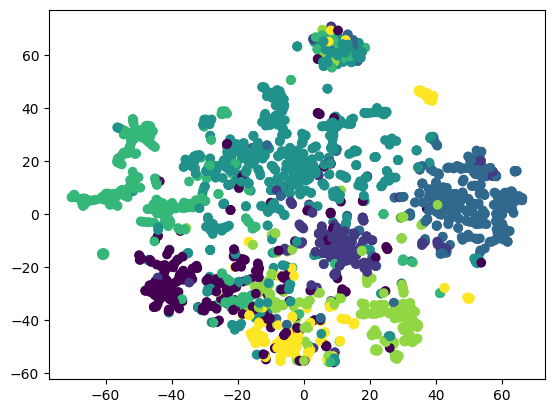

In [22]:
# t-SNE를 통한 시각화
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data.y)
plt.show()

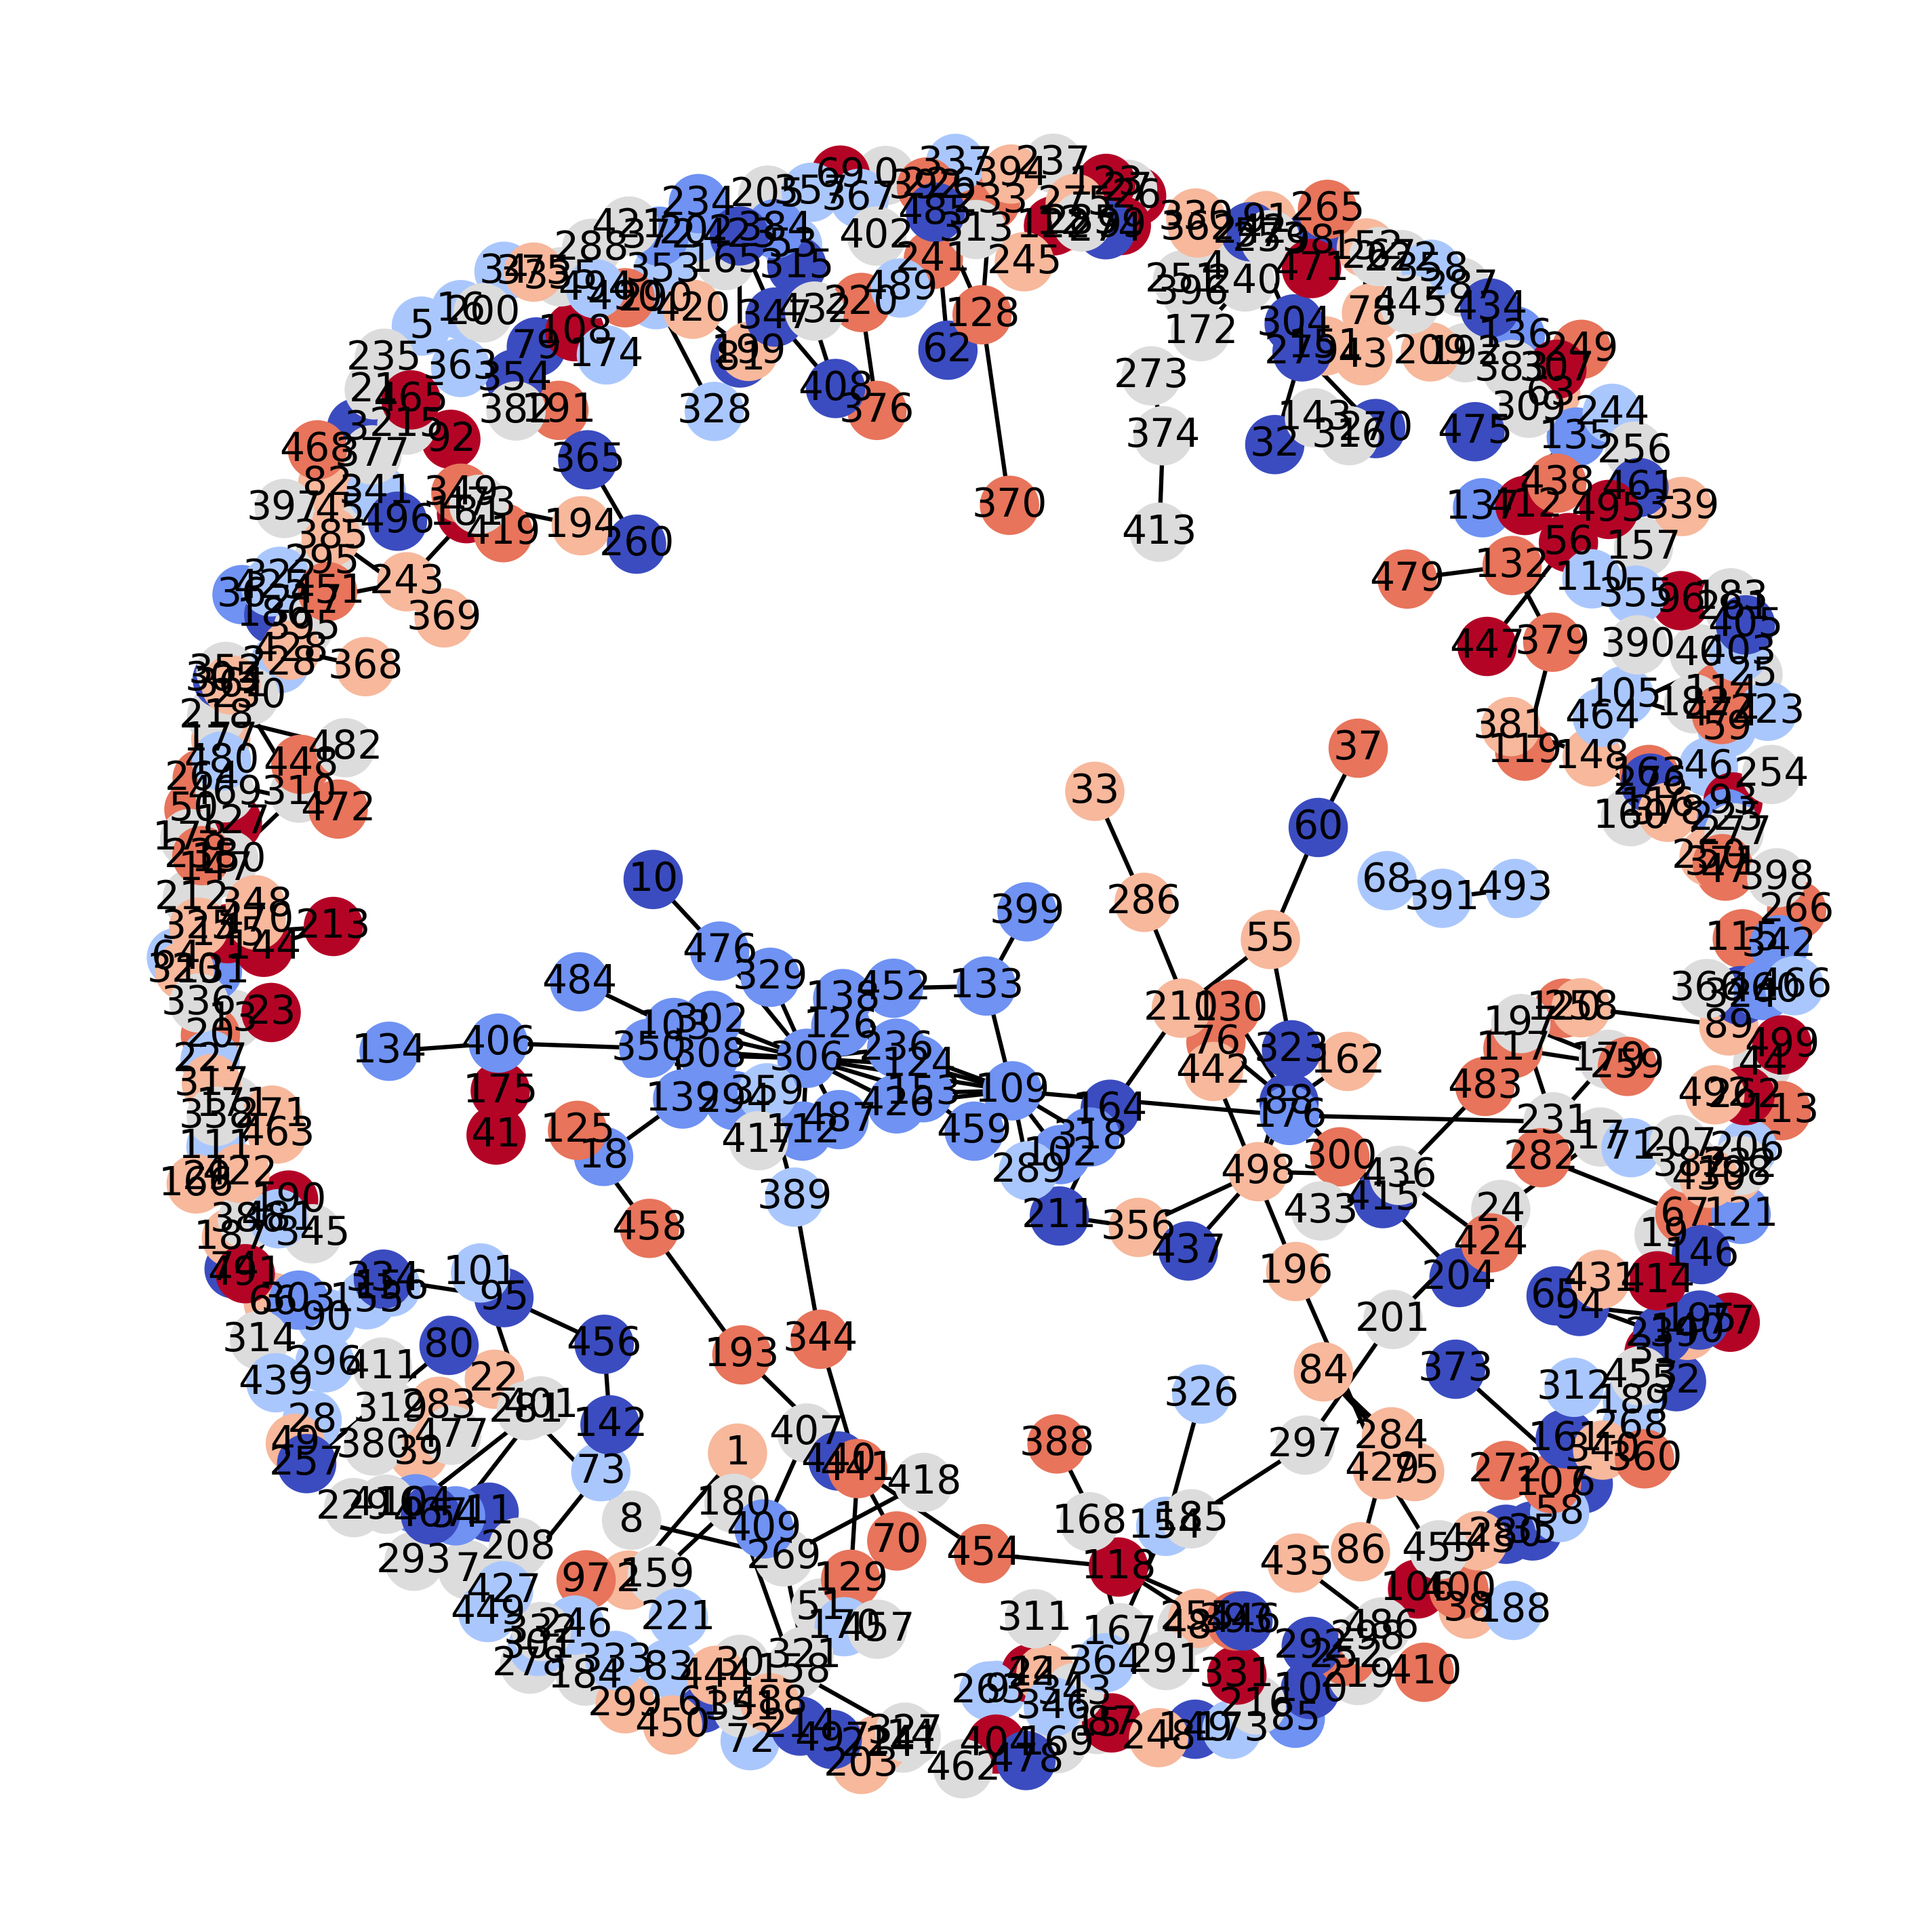

In [23]:
# 레이블 추출
labels = data.y.numpy()

# 노드 선택 (예: 첫 50개 노드)
selected_nodes = range(500)
subG = G.subgraph(selected_nodes)

# 레이블에 따른 색상 매핑
label_color_mapping = {
    label: idx for idx, label in enumerate(np.unique(labels[selected_nodes]))
}
node_colors = [label_color_mapping[label] for label in labels[selected_nodes]]

plt.figure(figsize=(12, 12), dpi=300)
plt.axis("off")
nx.draw_networkx(
    subG,
    pos=nx.spring_layout(
        subG, seed=42, k=0.15
    ),  # k 인자를 조정하여 노드 간의 거리를 늘릴 수 있습니다.
    node_color=node_colors,
    node_size=400,  # 노드의 크기를 줄입니다.
    edge_color="black",  # 엣지의 색상을 변경합니다.
    width=1.5,  # 엣지의 두께를 두꺼워지도록 설정합니다.
    cmap="coolwarm",
    font_size=14,
    font_color="black",
)
plt.show()

## Node Classification
- 노드를 특정한 카테고리나 클래스로 분류하는 작업
- 유저의 행동패턴을 예측하거나, 추천시스템에서 유저에게 가장 관련도가 높은 item을 추천하는 task로 활용됨


### 이번 여행의 마지막 코스로는🧭
1. RandomForestClassifier에 Embedding을 학습시키고

2. Node classification을 진행한 다음

3. 분류 보고서를 확인해 볼게요.

In [24]:
# 레이블이 있는 노드만 선택
labels = data.y.numpy()
idx_train = data.train_mask.numpy()
idx_test = data.test_mask.numpy()

X_train, y_train = embeddings[idx_train], labels[idx_train]
X_test, y_test = embeddings[idx_test], labels[idx_test]

# 랜덤 포레스트 분류기 학습
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.62      0.59       130
           1       0.57      0.80      0.67        91
           2       0.75      0.88      0.81       144
           3       0.85      0.54      0.66       319
           4       0.69      0.62      0.65       149
           5       0.63      0.68      0.65       103
           6       0.39      0.69      0.50        64

    accuracy                           0.66      1000
   macro avg       0.63      0.69      0.65      1000
weighted avg       0.70      0.66      0.66      1000



In [29]:
data.train_mask.numpy()

array([ True,  True,  True, ..., False, False, False])

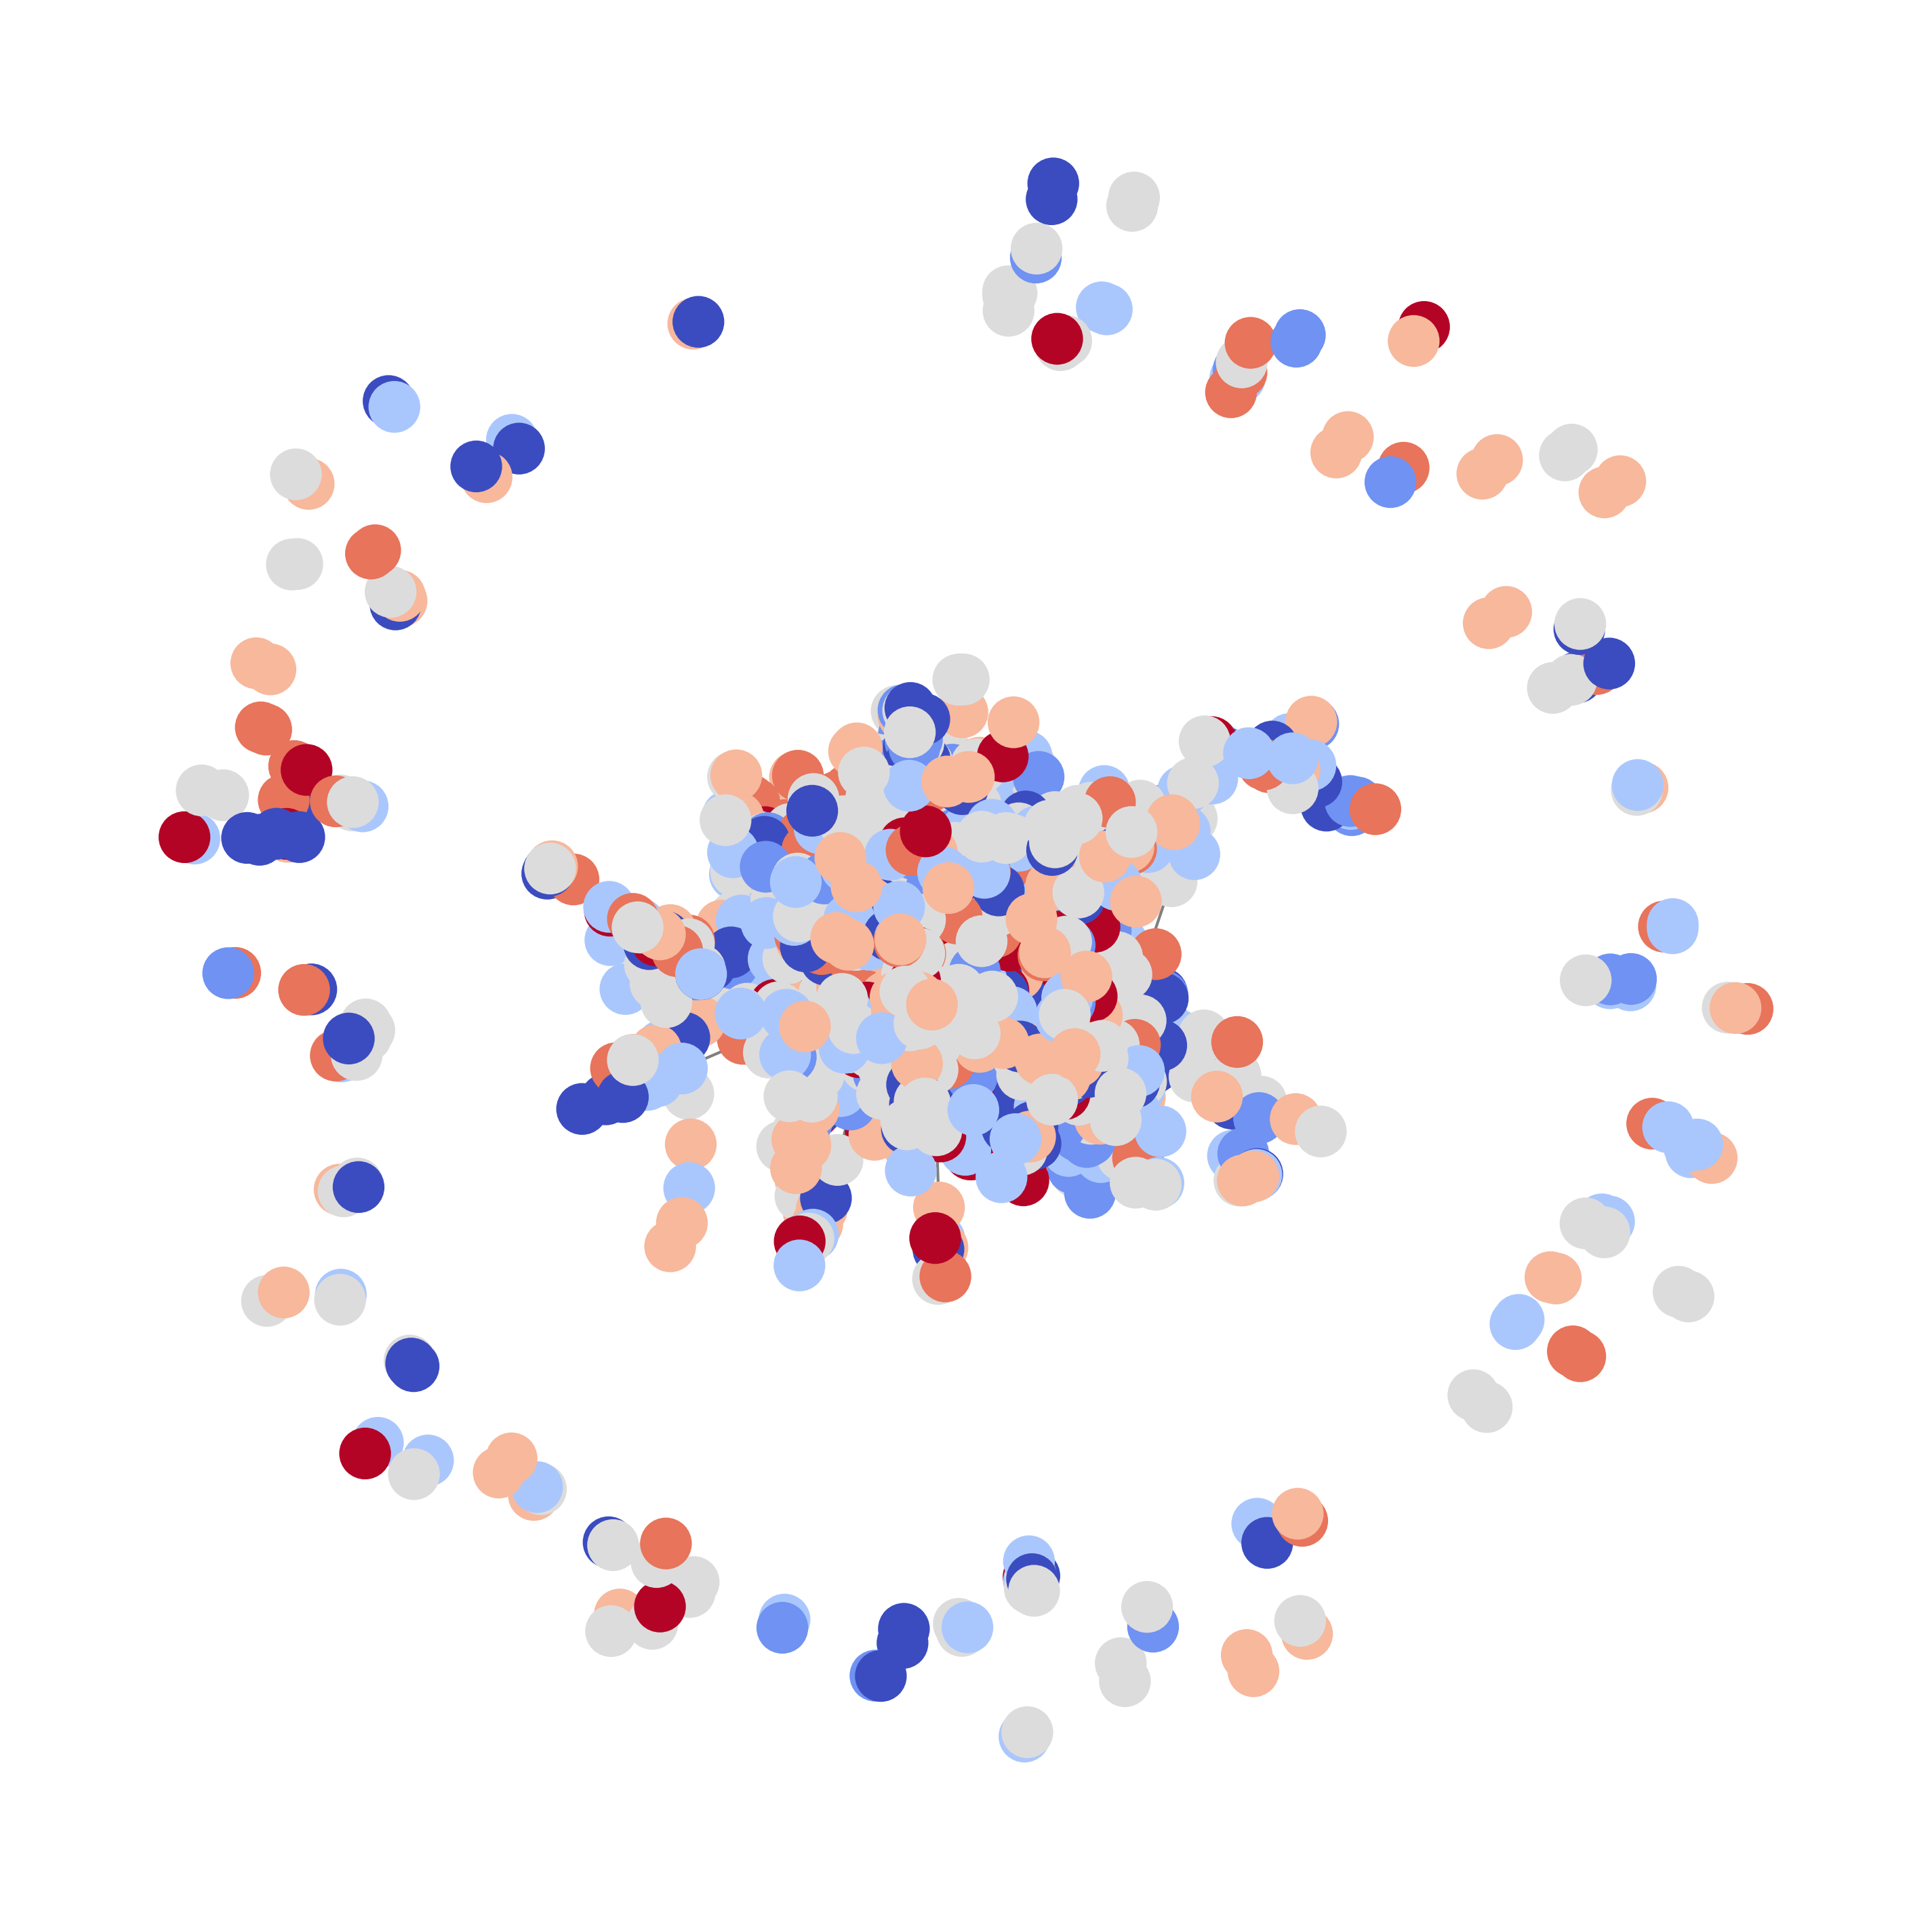

In [31]:
plt.figure(figsize=(12, 12), dpi=300)
plt.axis("off")
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=0),
    node_color=labels,
    node_size=300,  # 노드 크기 조정
    cmap="coolwarm",
    font_size=14,
    font_color="white",
    edge_color="grey",  # 엣지 색상 설정
    width=1,  # 엣지 두께 설정
    with_labels=False,
)  # 노드 라벨 표시 여부. True로 바꾸면 노드 이름이 출력됩니다!